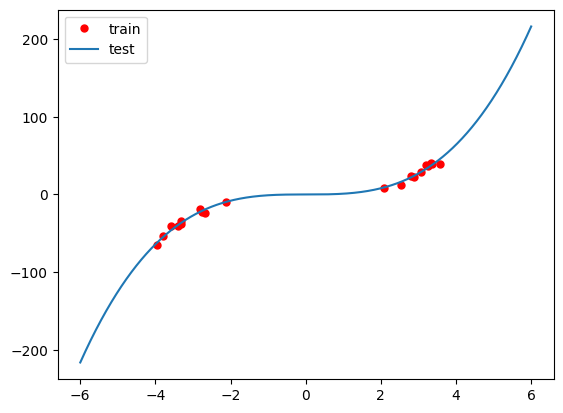

<Figure size 640x480 with 0 Axes>

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from regressionutil import mlp,train,plot_bayes_method,toy_dataset

n_train = 20; n_test = 10000; std = 3
train_x,train_y,test_x,test_y = toy_dataset(n_train, n_test, std)

## plot train
plt.plot(train_x,train_y,'ro',markersize=5,label='train')
plt.plot(test_x,test_y,label='test')
plt.legend()
plt.show()
plt.savefig('plot.pdf',format='pdf')

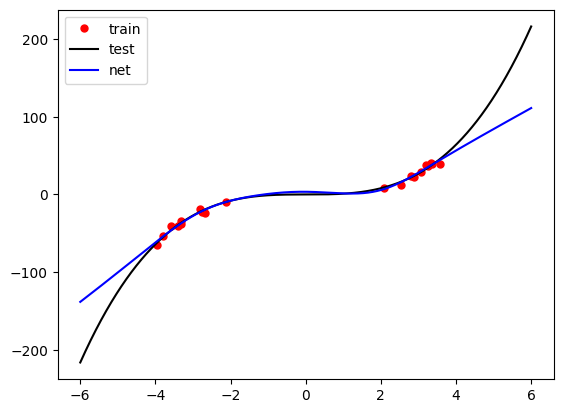

<Figure size 640x480 with 0 Axes>

In [13]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),n_train)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),n_test)

## Set up neural network.
map_net = mlp(width=50)

map_epochs = 10000; map_lr = 0.001
mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=0)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in range(map_epochs):
    train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)

## plot train
plt.plot(train_x,train_y,'ro',markersize=5,label='train')
plt.plot(test_x,test_y,'k',label='test')
plt.plot(test_x, map_net(test_x).detach(), 'b', label='net')
plt.legend()
plt.show()
plt.savefig('plotfitted.pdf',format='pdf')

In [14]:
from nuqls.posterior import Nuqls

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuqls_posterior = Nuqls(map_net, task='regression', full_dataset=False)
res = nuqls_posterior.train(train=train_data, 
                      train_bs=20, 
                      scale=5, 
                      S=10, 
                      epochs=1000, 
                      lr=1e-4, 
                      mu=0.9, 
                      verbose=True)
nuql_test_preds = nuqls_posterior.test(test_data, test_bs=50)

nuql_mu = nuql_test_preds.mean(1)
nuql_var = nuql_test_preds.var(1)

100%|██████████| 1000/1000 [00:02<00:00, 355.96it/s, max_loss=15.2, resid_norm=0.014, gpu_mem=0]


Posterior samples computed!


In [15]:
from nuqls.posterior import Nuqls

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuqls_posterior = Nuqls(map_net, task='regression', full_dataset=True)
res = nuqls_posterior.train(train=train_data,
                      scale=5, 
                      S=10, 
                      epochs=1000, 
                      lr=1e-4, 
                      mu=0.9, 
                      verbose=True)
nuql_test_preds = nuqls_posterior.test(test_data, test_bs=10)

nuql_mu = nuql_test_preds.mean(1)
nuql_var = nuql_test_preds.var(1)

100%|██████████| 1000/1000 [00:00<00:00, 1181.41it/s, mean_loss=15.5, resid_norm=0.0247, gpu_mem=0]


Posterior samples computed!


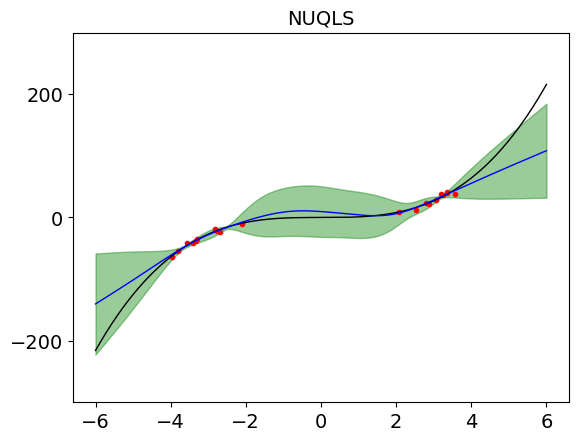

In [ ]:
fs, ms, lw = 14, 3, 1
f, (ax1) = plt.subplots(1,1)

## Plot NUQLs
plot_bayes_method(ax1,nuql_mu,nuql_var,
                  train_x,train_y,test_x,test_y,
                  'NUQLS',fs=fs, ms=ms, lw=lw)

plt.show()